In [1]:
import faiss
import os
import pandas as pd
import numpy 
import glob
import numpy as np
from skimage import measure, transform, feature
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# DB details
NPZ_FEAT_SRC = "/local/cs572/rchan31/codespace/BaselinePrototype/npz_file_saves/COMPACT_NPZ_DELF_FEATS/"
FAISS_INDEX_FILE = "/local/cs572/rchan31/fINALwEEK/FAISSIndex/FAISS_delf_v1.index"
IMG_SRC_PATH = "/local/cs572/cziems/index/"

LOOKUP_CSV = "/local/cs572/rchan31/fINALwEEK/csv_lookups/FAISS_delf_v1_CSV_lookup.csv"
N_INDEX = 952133

In [3]:
cpu_index = faiss.read_index(FAISS_INDEX_FILE)

cpu_index.ntotal

952133

In [7]:
# Query details
Q_NPZ_FEAT_SRC = "/local/cs572/rchan31/fINALwEEK/COMPACT_NPZ_DELF_test_FEATS"
Q_IMG_SRC_PATH = "/local/cs572/cziems/test/"

Q_LOOKUP_CSV = "/local/cs572/rchan31/fINALwEEK/csv_lookups/processed_retrieval_solutions.csv"
Q_N_INDEX = 667

In [10]:
# Sample query
example_q_feat_file = sorted(glob.glob(os.path.join(Q_NPZ_FEAT_SRC, "*.npz")))[0]
print(example_q_feat_file.split("/")[-1])

q_vec_desc = np.load(example_q_feat_file)["descriptors"]
q_vec = np.asarray(q_vec_desc[0, :], dtype=np.float32)

q_vec.shape

005a1206a50ad018.npz


(40,)

In [11]:
TOP_K = 100

cpu_index.nprobe = 100

query_vector = np.expand_dims(q_vec, axis=0)

distances, indices = cpu_index.search(query_vector, TOP_K)
print(distances.shape)
print(indices.shape)

indices

(1, 100)
(1, 100)


array([[ 12852, 773578,  65763, 201768, 761089, 426602, 297320, 345926,
        485120, 749906,  85262, 922906, 442683, 951648, 278872, 372560,
        778272, 924351, 388964, 172717, 534095,  39719, 908449, 185345,
        828105, 738833, 594915, 323453, 726508, 185955,  30415, 215168,
        506010, 913102, 519916, 831195, 518574, 169484,  65417, 188069,
        456238, 165617, 243174, 113125, 252749, 173108,  14222, 624844,
        261806, 815622, 793789,  88221, 116061, 656343, 252744, 779263,
        507517, 740873, 300253, 117199, 404795, 432850, 551539, 156317,
        515115, 881103, 391883, 742887,    533, 839594, 650055,  25903,
        149045, 303107, 941903, 517618, 199676, 845286, 222991, 882410,
        741418, 190958, 838349, 128333, 462808, 194729,  23770, 372176,
        659320, 521073, 200498,  34638,  36175, 523030, 731046, 642017,
        624004, 802960, 669939, 130495]])

In [12]:
df = pd.read_csv(LOOKUP_CSV)
df.head()

,Unnamed: 0,filenames
0,0,00002469b818f290
1,1,0000298d976221f3
2,2,00002e4e382333bf
3,3,000036329c35b65c
4,4,0000394edaaa55b1


Number of query-feature size :  826
Matched filename :  037c8ca1724ccb90
Number of dbImge-feature size :  1000
Minimum number of feature vectors :  826
(1000, 2)
(826, 2)
Found 15 inliers


<Figure size 576x576 with 0 Axes>

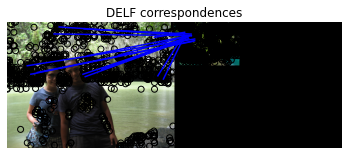

In [39]:
insta_imageID = ""


def match_retrievals(q_idx): # per query
    
    q_locations_x = np.asarray(np.load(example_q_feat_file)["locations_x"], np.int32)
    q_locations_y = np.asarray(np.load(example_q_feat_file)["locations_y"], np.int32)
    q_locations = np.asarray([q_locations_x, q_locations_y]).T
    
    
    num_features_q = q_locations.shape[0]
    print("Number of query-feature size : ", num_features_q)

    for topk_idx, index_num in enumerate(indices[q_idx]):
        
#         if topk_idx != 1:
#             continue

        fileID = df.loc[index_num]["filenames"]
        print("Matched filename : ", fileID)
        
        npz_filename_path = os.path.join(NPZ_FEAT_SRC, "%s.npz" % fileID)
        insta_imageID = "%s.jpg" % fileID
        npz_data = np.load(npz_filename_path)
        
        inst_location_x = np.asarray(npz_data["locations_x"], np.int32)
        inst_location_y = np.asarray(npz_data["locations_y"], np.int32)
        db_locations = np.asarray([inst_location_x, inst_location_y]).T

        num_features_db = db_locations.shape[0]
        print("Number of dbImge-feature size : ", num_features_db)
        
        min_feat_len = min(num_features_q, num_features_db)
        print("Minimum number of feature vectors : ", min_feat_len)


        # Perform geometric verification using RANSAC.
        print(db_locations.shape)
        print(q_locations.shape)
        _, inliers = measure.ransac((db_locations[:min_feat_len, :],
                                     q_locations[:min_feat_len, :]),
                                      transform.AffineTransform,
                                      min_samples=3,
                                      residual_threshold=20,
                                      max_trials=1000)

        print('Found %d inliers' % sum(inliers))

        # Visualize correspondences, and save to file.
        image_db_path = os.path.join(IMG_SRC_PATH, insta_imageID)
        image_q_path = os.path.join(Q_IMG_SRC_PATH, "%s.jpg" % example_q_feat_file.split("/")[-1][:-4])
        output_image = "./hello_delete.jpg"
        plt.figure(figsize=(8, 8))
        _, ax = plt.subplots()
        img_1 = mpimg.imread(image_db_path)
        img_2 = mpimg.imread(image_q_path)
        inlier_idxs = np.nonzero(inliers)[0]
        feature.plot_matches(
          ax,
          img_1,
          img_2,
          db_locations,
          q_locations,
          np.column_stack((inlier_idxs, inlier_idxs)),
          matches_color='b')
        ax.axis('off')
        ax.set_title('DELF correspondences')
        plt.savefig(output_image)
        
        break

    
for q_idx in range(1):
    match_retrievals(q_idx)

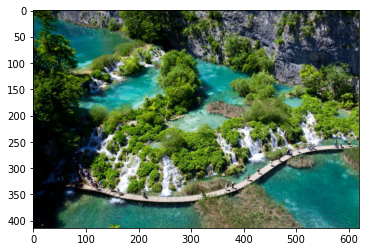

In [40]:
q_image_tmp_path = os.path.join(Q_IMG_SRC_PATH, "%s.jpg" % example_q_feat_file.split("/")[-1][:-4])
q_img_tmp = mpimg.imread(q_image_tmp_path)
plt.imshow(q_img_tmp)

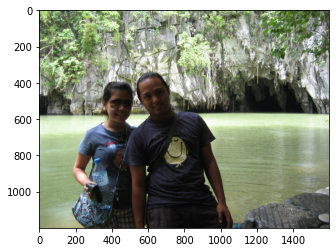

In [42]:
db_image_tmp_path = os.path.join(IMG_SRC_PATH, "037c8ca1724ccb90.jpg")
db_img_tmp = mpimg.imread(db_image_tmp_path)
plt.imshow(db_img_tmp)